In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

#### PATHS- set for multiple computers, see bottom to SET PATH

In [2]:
#ASO lidar - netCDFs & integers in [mm]
ars_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent_data_downsize/nc/20*/*int.nc'
# mac_path = ''
bsu_path = '/Users/meganmason491/Documents/research/sierra/data/mm/20*/*int.nc'
sonic_path = '/home/meganmason/Research/Sierra/data/mm/20*/*int.nc'
geohack_path = '/srv/shared/deep_stac/data/snowdepth/netcdf/20*/*int.nc'

#DEM & Mask for Tuolumne
ars_topo_path = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc'
# mac_topo_path =
bsu_topo_path = '/Users/meganmason491/Documents/research/sierra/data/topo.nc'
sonic_topo_path = '/home/meganmason/Research/Sierra/data/topo.nc'
geohack_topo_path = '/srv/shared/deep_stac/data/topo.nc'


# ~~ SET PATH HERE ~~ #
path = ars_path
topo_path = ars_topo_path

#### FILEPATH LIST AND DATE PARSING

In [3]:
# filepath list, lidar
flist = sorted(glob.glob(path))
print('# of lidar files as input:', len(flist))

# Parse dates, store as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splits fname on '_' saves first

# flight dates, parsed from filename
dates = pd.to_datetime(fparse) #pandas datetime variable, lidar dates
print('dates, file type is:', type(dates))

# of lidar files as input: 51
dates, file type is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### OPTION: run a smaller chunk, peak, etc.
Activate if you want to run 2 flights, peak flights, etc.

In [4]:
# '''first 2 files'''
# # flist = flist[:2] #first 6 are just 2013
# # dates = dates[:2]

# '''peak snow depth dates....(?)'''
# flist = list(flist[i] for i in (0,7,22,28,41,49))
# dates = list(dates[i] for i in (0,7,22,28,41,49))

# print('# of lidar files as input:', len(flist))
# print('# of flight dates', len(dates))

#### BUILD XARRAY DATASET
* open multiple files (mf) from file list (lidar res = 3m)
* name the concatinating dimention, 'time'
* 'nested' vs 'comb_by_cords' .....not totally clear, but no error!
* set chunk size (prefered is 1 million in size (1000x1000)
* activate DASK with parallel
* rename data to 'snow' on the fly
* drop a variable
* close to remove from memory

#### ADD 'TIME' COORDINATE 

* time coord from file name dates, by default populates with 'time' dimension

#### FLIP 'Y' COORD (corrects orientation for imshow() ) 
* flips horizonally (but actually flips 'Y')
    *NOTE: tried several options flipud, flip w/ axis=0, etc. 
* flip causes DataSet to become a DataArray, set back to DataSet
    *NOTE: changes set chunk size, solution - set chunk size when compiled netCDF is loaded in analysis

In [5]:
# build xarray
ds=xr.open_mfdataset(flist, 
                     concat_dim='time', 
                     combine='nested', 
                     chunks={'x':1000, 'y':1000}, 
                     parallel=True).rename({'Band1':'snow'}).drop('transverse_mercator')

ds.close()

# add 'time' coord
ds['time'] = (['time'], dates) 

# flip 'y' up/down
ds=np.flip(ds.snow,1) 
ds=ds.to_dataset()

ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>

#### SHOW ONE FLIGHT FROM DS
proof that ds loaded properly

Text(0.5, 1.0, 'First snow depth, check orientation/units/etc')

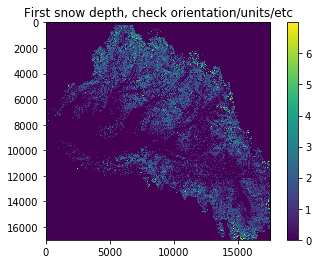

In [6]:
plt.imshow(ds.snow[0]/1000) #[m]
plt.colorbar()
plt.title('First snow depth, check orientation/units/etc')

#### Open topo.nc (dem, mask, veg_height)
Cell size is 3m

In [7]:
topo = xr.open_dataset(topo_path, drop_variables=['veg_tau','veg_k','veg_type','projection'], chunks={'x':1000, 'y':1000})
topo.close()

# assign 'mask' as coord
ds = ds.assign_coords(mask=topo.mask) #this shows up in ds, not topo

topo

<xarray.Dataset>
Dimensions:     (x: 17569, y: 17002)
Coordinates:
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
Data variables:
    veg_height  (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem         (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    mask        (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
    generation_command:  /usr/local/bin/basin_setup -f corrected_tuolumne_sub...

#### SHOW TOPO DATASET PLOTTED

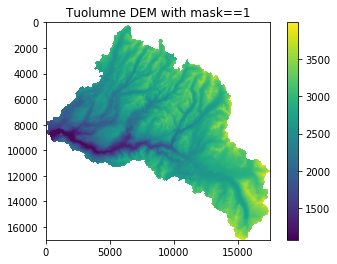

In [8]:
plt.imshow(topo.dem.where(ds.mask==1))
plt.colorbar()
plt.title('Tuolumne DEM with mask==1')
plt.show()

#### Concatenate topo layers with lidar DataSet (ds)

In [9]:
#add topo features to lidar DataSet (ds)
# ds['mask'] = (['y','x'],topo.mask) #could do this for mask, but instead choose to put as coord
ds['dem'] = (['y','x'],topo.dem)
ds['veg'] = (['y','x'],topo.veg_height)
# ds

#### SET MASK OVER DATASET

In [11]:
ds=ds.where(ds.mask==1)
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>

#### SHOW THAT MASK IS APPLIED TO DATASET
~ Do some subplots here to show this nicer.... ~

In [ ]:
plt.imshow(ds.snow[0], cmap='coolwarm'); plt.title('One snow depth image'); plt.show()
plt.imshow(ds.dem, cmap='jet'); plt.title('DEM'); plt.show()
plt.imshow(ds.veg, cmap='Greens'); plt.title('Veg Height'); plt.show()

#### CHANGE DTYPES BEFORE SAVING OUTPUT

In [16]:
#changes 'snow', 'dem', and 'veg' -- less than ideal
ds_snow_int=ds.snow
# ds_snow_int=ds.snow.astype(np.int16, copy=False)
ds_snow_int

<xarray.DataArray 'snow' (time: 51, y: 17002, x: 17569)>
dask.array<shape=(51, 17002, 17569), dtype=float32, chunksize=(1, 2, 1000)>
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  transverse_mercator

In [ ]:
ds['snow_int'] = (['y','x'],ds_snow_int.snow)

In [ ]:
#uncomment when you want to save:
# ds.to_netcdf('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc')